**Import libraries and define system parameters**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from utils import calculate_num_sensors, calculate_graph_matrices, is_graph_connected, get_field_function, get_sensor_measurements, visualize_graphs
from utils import calculate_error

FIELD_SIZE = 100
FIELD_RANGE = np.array([[0, FIELD_SIZE], [0, FIELD_SIZE]]) 
field_function = get_field_function()

COMM_RANGE = 30
NUM_SENSORS = calculate_num_sensors(COMM_RANGE, FIELD_SIZE, 2)
print("Selected number of sensors:", NUM_SENSORS)

Selected number of sensors: 103


**Generate random graph**

The graph is connected.
Average temperature: 13.28 C


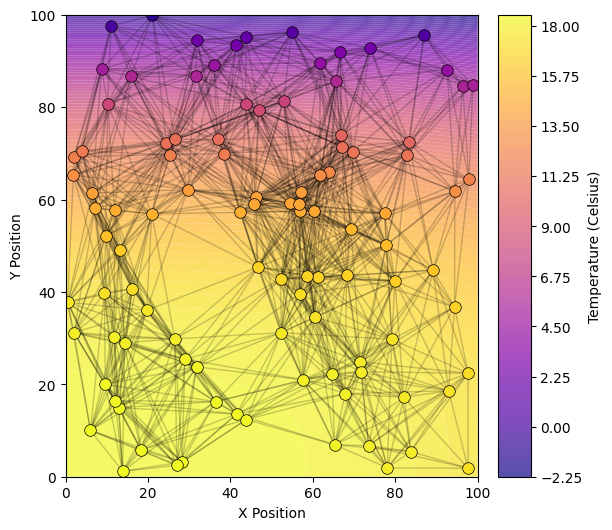

In [9]:
# Set random seed for reproducibiliy
np.random.seed(0)

# Randomly generate sensor locations within the field
sensor_locations = np.array([np.random.uniform(FIELD_RANGE[0,0], FIELD_RANGE[0,1], NUM_SENSORS),
                            np.random.uniform(FIELD_RANGE[1,0], FIELD_RANGE[1,1], NUM_SENSORS)])

# Calculate the adjacency matrix, degree matrix, and Laplacian matrix
adjacency_matrix, degree_matrix, laplacian_matrix = calculate_graph_matrices(sensor_locations, COMM_RANGE)
# Determine if the graph is connected
if not is_graph_connected(laplacian_matrix):
    print("Warning: The graph is not connected.")
else:
    print("The graph is connected.")

# Generate sensor measurements from the field function
sensor_measurements = get_sensor_measurements(sensor_locations, field_function, 0)
average_temperature = np.mean(sensor_measurements)
print("Average temperature:", "{:.2f}".format(average_temperature), "C")

# Visualize the sensor locations and the communication graph
visualize_graphs(sensor_locations, adjacency_matrix, field_function, sensor_measurements)

**Randomized Gossip**

Text(0.5, 1.0, 'Randomized Gossip Algorithm: Error vs Iteration')

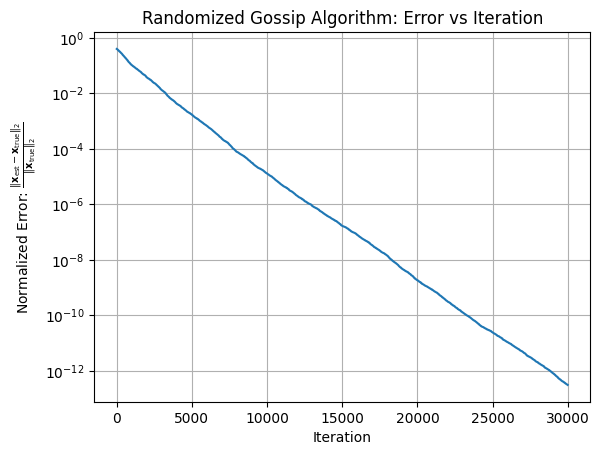

In [10]:
# Implements the randomized gossip algorithm for the specified number of iterations
def randomized_gossip(adjacency_matrix, sensor_measurements, num_iter):
    num_sensors = adjacency_matrix.shape[0]
    error_vals = []
    true_average = np.mean(sensor_measurements) * np.ones(num_sensors)
    est_average = sensor_measurements.copy()
    
    for iter in range(0, num_iter):
        # Randomly choose a sensor
        i = np.random.randint(0, num_sensors)
        # Randomly choose a neighbor 
        # TODO: find the P matrix that will optimize the gossip algorithm
        j = np.random.choice(np.where(adjacency_matrix[i] > 0)[0])
        # Compute the average of the two selected sensors
        average_val = 0.5*(est_average[i] + est_average[j])
        est_average[i] = average_val
        est_average[j] = average_val
        # Calculate the error
        error_val = calculate_error(est_average, true_average)
        error_vals.append(error_val)

    return error_vals, est_average

error_vals, est_average = randomized_gossip(adjacency_matrix, sensor_measurements, 30000)
plt.semilogy(error_vals)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel(r"Normalized Error: $\frac{\|\mathbf{x}_{\mathrm{est}} - \mathbf{x}_{\mathrm{true}}\|_2}{\|\mathbf{x}_{\mathrm{true}}\|_2}$")
plt.title("Randomized Gossip Algorithm: Error vs Iteration")